Data loaded successfully!
Dataset shape: (569, 33)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.1043

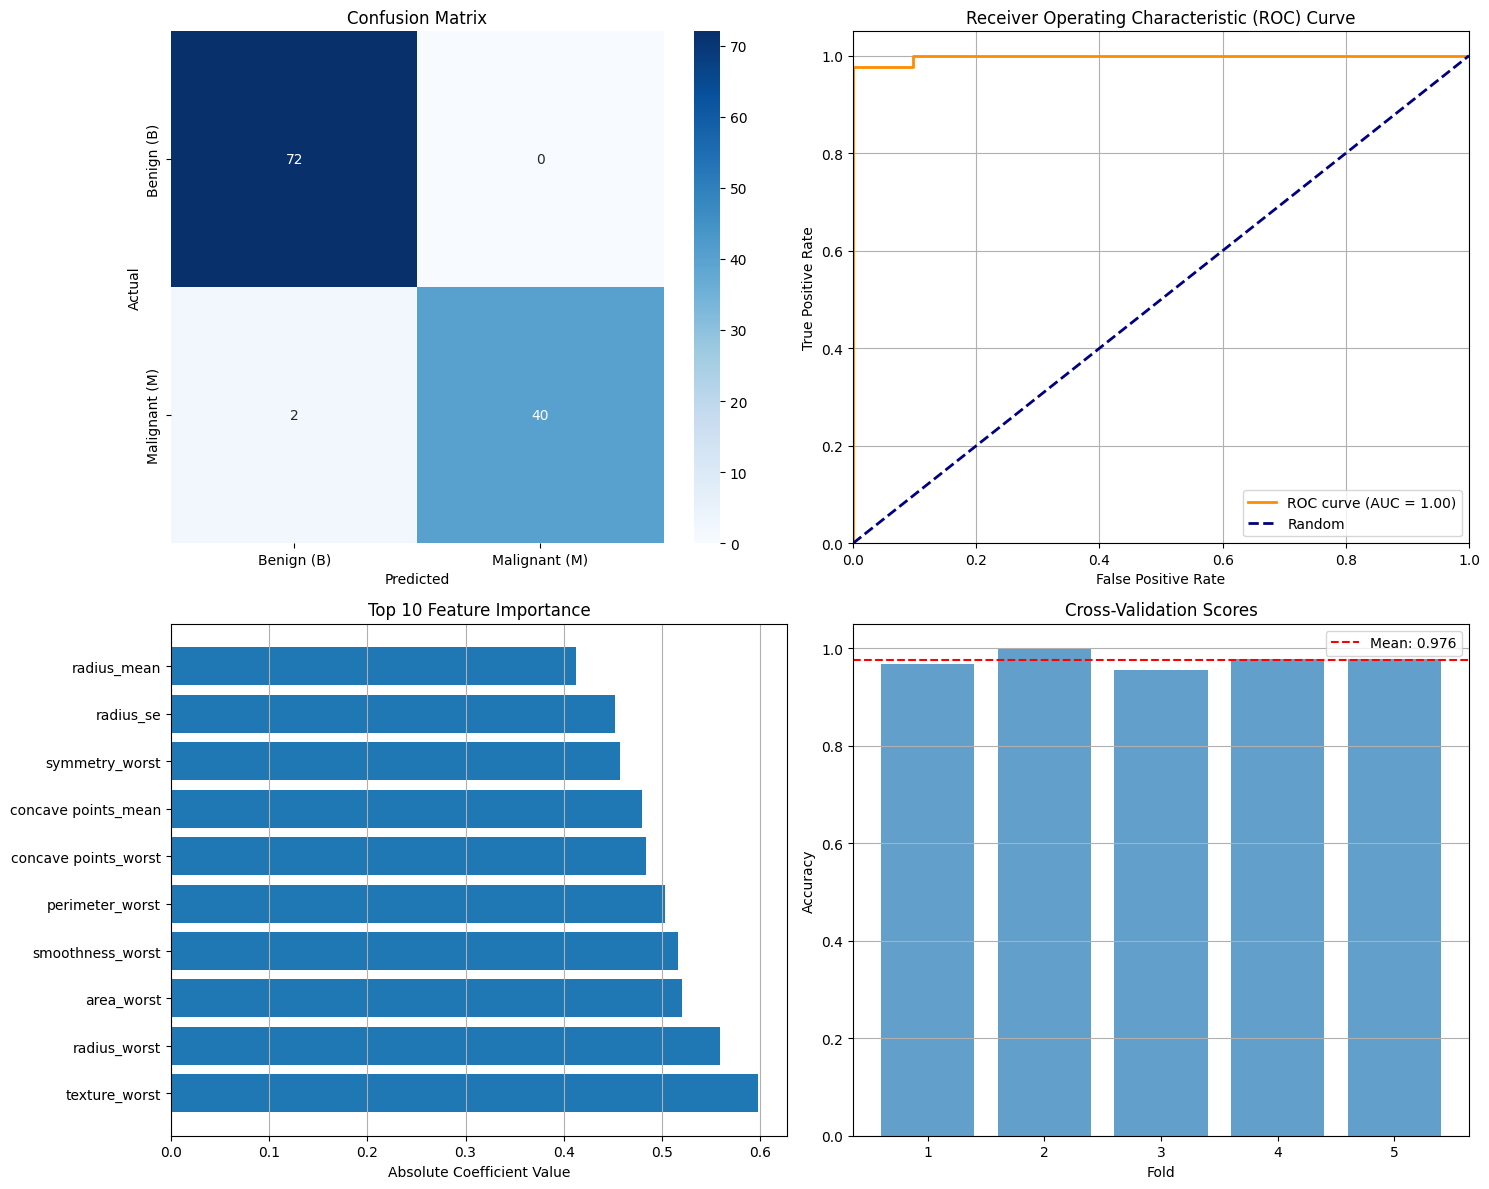


ADDITIONAL ANALYSIS

Top 5 parameter combinations:
Params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV Score: 0.9758 (+/- 0.0146)
----------------------------------------
Params: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV Score: 0.9758 (+/- 0.0146)
----------------------------------------
Params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV Score: 0.9736 (+/- 0.0149)
----------------------------------------
Params: {'C': 1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV Score: 0.9736 (+/- 0.0149)
----------------------------------------
Params: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV Score: 0.9692 (+/- 0.0162)
----------------------------------------

Model Interpretation:
- The model classifies breast tumors as Benign (0) or Malignant (1)
- Best regularization parameter (C): 0.1
- Regularization type: l2
- Solver algorithm: liblinear


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Load the data
try:
    # Try reading with different approaches to handle potential formatting issues
    data = pd.read_csv('data.csv')
    print("Data loaded successfully!")
    print(f"Dataset shape: {data.shape}")
    print("\nFirst few rows:")
    print(data.head())
    print("\nColumn names:")
    print(list(data.columns))
except Exception as e:
    print(f"Error loading data: {e}")
    print("Trying alternative reading method...")
    try:
        # Try reading without header and set columns manually
        data = pd.read_csv('daa.txt', header=0)
        print("Data loaded with alternative method!")
        print(f"Dataset shape: {data.shape}")
    except Exception as e2:
        print(f"Failed to load data: {e2}")
        exit()

# Basic data exploration
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

print(f"\nDataset Info:")
print(f"- Number of rows: {data.shape[0]}")
print(f"- Number of columns: {data.shape[1]}")

print(f"\nColumn names:")
print(data.columns.tolist())

print(f"\nData types:")
print(data.dtypes.value_counts())

print(f"\nMissing values:")
print(data.isnull().sum().sum())

# Check target variable distribution
print(f"\nTarget variable (diagnosis) distribution:")
print(data['diagnosis'].value_counts())
print(f"Percentage distribution:")
print(data['diagnosis'].value_counts(normalize=True) * 100)

# Data Preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# First, let's examine the data more carefully
print("Examining data structure:")
print(f"Data dtypes:\n{data.dtypes}")
print(f"\nFirst few values of each column:")
for col in data.columns[:5]:  # Show first 5 columns
    print(f"{col}: {data[col].head().tolist()}")

# Check for any obvious issues in the data
print(f"\nUnique values in diagnosis column: {data['diagnosis'].unique()}")

# Encode the target variable (M = Malignant = 1, B = Benign = 0)
label_encoder = LabelEncoder()
data['diagnosis_encoded'] = label_encoder.fit_transform(data['diagnosis'])

print(f"Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

# Prepare features and target
# Remove non-numeric columns and any ID columns
columns_to_drop = ['diagnosis', 'diagnosis_encoded']

# Check if there's an ID column (usually the first column)
if 'id' in data.columns.str.lower():
    id_col = [col for col in data.columns if 'id' in col.lower()][0]
    columns_to_drop.append(id_col)
    print(f"Found ID column: {id_col}, will be dropped")
elif data.columns[0].dtype == 'object' or 'id' in str(data.columns[0]).lower():
    # If first column looks like an ID
    columns_to_drop.append(data.columns[0])
    print(f"First column {data.columns[0]} appears to be ID, will be dropped")

X = data.drop(columns_to_drop, axis=1)
y = data['diagnosis_encoded']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle any potential issues with feature columns
print(f"\nFeature columns data types:")
print(X.dtypes.value_counts())

# Convert all features to numeric and handle errors more carefully
print(f"\nConverting features to numeric...")
original_shape = X.shape
for col in X.columns:
    # Check if column is already numeric
    if not pd.api.types.is_numeric_dtype(X[col]):
        print(f"Converting non-numeric column: {col}")
        X[col] = pd.to_numeric(X[col], errors='coerce')

print(f"Conversion completed. Shape remains: {X.shape}")

# Check for missing values after conversion
missing_before = X.isnull().sum()
total_missing = missing_before.sum()
print(f"\nMissing values in features after conversion: {total_missing}")

if total_missing > 0:
    print("Columns with missing values:")
    for col in missing_before[missing_before > 0].index:
        print(f"  {col}: {missing_before[col]} missing values")
    
    # Fill missing values with median
    print("Filling missing values with median...")
    X = X.fillna(X.median())
    
    # Verify no missing values remain
    remaining_missing = X.isnull().sum().sum()
    print(f"Missing values after imputation: {remaining_missing}")
    
    if remaining_missing > 0:
        # If still missing values, try filling with 0
        X = X.fillna(0)
        print("Filled remaining missing values with 0")

# Final check for infinite values
print(f"\nChecking for infinite values...")
inf_count = np.isinf(X.values).sum()
if inf_count > 0:
    print(f"Found {inf_count} infinite values, replacing with median...")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

print(f"Final feature matrix shape: {X.shape}")
print(f"Final feature matrix info:")
print(f"  - Contains NaN: {X.isnull().any().any()}")
print(f"  - Contains Inf: {np.isinf(X.values).any()}")
print(f"  - All numeric: {X.dtypes.apply(pd.api.types.is_numeric_dtype).all()}")

# Show some basic statistics
print(f"\nBasic statistics of features:")
print(X.describe().iloc[:, :5])  # Show first 5 features

# Split the data
print("\n" + "="*50)
print("DATA SPLITTING")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set class distribution:")
print(pd.Series(y_train).value_counts())
print(f"Test set class distribution:")
print(pd.Series(y_test).value_counts())

# Feature Scaling
print("\n" + "="*50)
print("FEATURE SCALING")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Training features mean: {np.mean(X_train_scaled):.6f}")
print(f"Training features std: {np.std(X_train_scaled):.6f}")

# Feature Selection (Optional - using SelectKBest)
print("\n" + "="*50)
print("FEATURE SELECTION")
print("="*50)

# Double-check data quality before feature selection
print("Pre-feature selection data quality check:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X contains NaN: {X.isnull().any().any()}")
print(f"X contains Inf: {np.isinf(X.values).any()}")
print(f"y contains NaN: {pd.Series(y).isnull().any()}")

# Ensure X is a proper numpy array or DataFrame
X = pd.DataFrame(X)  # Ensure it's a DataFrame
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

print(f"After ensuring numeric data: {X.shape}")
print(f"Data types: {X.dtypes.unique()}")

# Final cleanup - ensure no NaN or infinite values
if X.isnull().any().any():
    print("Found NaN values, filling with median...")
    X = X.fillna(X.median())

if np.isinf(X.values).any():
    print("Found infinite values, replacing...")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

# Convert to float64 to ensure compatibility
X = X.astype(np.float64)

print(f"Final X data type: {X.dtypes.iloc[0]}")
print(f"Final check - NaN: {X.isnull().any().any()}, Inf: {np.isinf(X.values).any()}")

# Determine k based on available features
max_k = min(20, X.shape[1])  # Use at most 20 features or all available features
print(f"Selecting top {max_k} features out of {X.shape[1]} available")

# Select top k features
k_best = SelectKBest(score_func=f_classif, k=max_k)

try:
    X_train_selected = k_best.fit_transform(X_train_scaled, y_train)
    X_test_selected = k_best.transform(X_test_scaled)
    
    # Get selected feature names
    feature_names = X.columns.tolist()
    selected_features = [feature_names[i] for i in k_best.get_support(indices=True)]
    
    print(f"Successfully selected {len(selected_features)} features")
    print(f"Selected {len(selected_features)} best features:")
    
    for i, feature in enumerate(selected_features):
        score = k_best.scores_[k_best.get_support(indices=True)[i]]
        print(f"{i+1:2d}. {feature}: {score:.2f}")
        
except Exception as e:
    print(f"Error in feature selection: {e}")
    print("Using all features instead...")
    X_train_selected = X_train_scaled
    X_test_selected = X_test_scaled
    selected_features = X.columns.tolist()
    print(f"Using all {len(selected_features)} features")

# Logistic Regression with GridSearchCV
print("\n" + "="*50)
print("LOGISTIC REGRESSION WITH GRIDSEARCHCV")
print("="*50)

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'penalty': ['l1', 'l2', 'elasticnet'],        # Regularization type
    'solver': ['liblinear', 'saga'],              # Algorithm to use
    'max_iter': [1000, 2000, 3000]               # Maximum number of iterations
}

# Note: Some combinations are invalid (e.g., l1 with lbfgs), so we'll use liblinear and saga
param_grid_refined = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000, 2000]
}

print("Parameter grid for GridSearchCV:")
for key, value in param_grid_refined.items():
    print(f"{key}: {value}")

# Initialize Logistic Regression
logistic_regression = LogisticRegression(random_state=42)

# Perform GridSearchCV
print(f"\nPerforming GridSearchCV with 5-fold cross-validation...")

grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid_refined,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',      # Scoring metric
    n_jobs=-1,              # Use all available cores
    verbose=1               # Print progress
)

# Fit GridSearchCV (using selected features)
grid_search.fit(X_train_selected, y_train)

print(f"\nGridSearchCV completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

y_train_pred = best_model.predict(X_train_selected)
y_test_pred = best_model.predict(X_test_selected)

y_train_pred_proba = best_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training AUC-ROC: {train_auc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Detailed classification report
print(f"\nClassification Report (Test Set):")
target_names = ['Benign (B)', 'Malignant (M)']
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion Matrix
print(f"\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Feature importance (coefficients)
print(f"\nTop 10 Most Important Features (by coefficient magnitude):")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'coefficient': best_model.coef_[0],
    'abs_coefficient': np.abs(best_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(feature_importance.head(10))

# Visualizations
print("\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.2f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True)

# 3. Feature Importance
top_features = feature_importance.head(10)
axes[1,0].barh(range(len(top_features)), top_features['abs_coefficient'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'])
axes[1,0].set_xlabel('Absolute Coefficient Value')
axes[1,0].set_title('Top 10 Feature Importance')
axes[1,0].grid(axis='x')

# 4. Cross-validation scores
axes[1,1].bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7)
axes[1,1].axhline(y=cv_scores.mean(), color='red', linestyle='--', 
                  label=f'Mean: {cv_scores.mean():.3f}')
axes[1,1].set_xlabel('Fold')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Cross-Validation Scores')
axes[1,1].legend()
axes[1,1].grid(axis='y')

plt.tight_layout()
plt.show()

# Additional Analysis
print("\n" + "="*50)
print("ADDITIONAL ANALYSIS")
print("="*50)

# Grid search results analysis
results_df = pd.DataFrame(grid_search.cv_results_)
print(f"\nTop 5 parameter combinations:")
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_results.iterrows():
    print(f"Params: {row['params']}")
    print(f"Mean CV Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print("-" * 40)

# Model interpretation
print(f"\nModel Interpretation:")
print(f"- The model classifies breast tumors as Benign (0) or Malignant (1)")
print(f"- Best regularization parameter (C): {best_model.C}")
print(f"- Regularization type: {best_model.penalty}")
print(f"- Solver algorithm: {best_model.solver}")

if best_model.C > 1:
    print(f"- High C value suggests the model prefers low regularization (complex model)")
else:
    print(f"- Low C value suggests the model prefers high regularization (simple model)")

# Performance summary
print(f"\n" + "="*50)
print("FINAL PERFORMANCE SUMMARY")
print("="*50)

print(f"Best Model Performance:")
print(f"- Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"- Test Set Accuracy: {test_accuracy:.4f}")
print(f"- Test Set AUC-ROC: {test_auc:.4f}")

if test_accuracy > 0.95:
    print(f"- Excellent performance! The model achieves very high accuracy.")
elif test_accuracy > 0.90:
    print(f"- Good performance! The model is reliable for classification.")
elif test_accuracy > 0.85:
    print(f"- Decent performance. Consider feature engineering or different algorithms.")
else:
    print(f"- Performance needs improvement. Consider data quality and algorithm choice.")

print(f"\nConfusion Matrix Interpretation:")
tn, fp, fn, tp = cm.ravel()
print(f"- True Negatives (Correctly predicted Benign): {tn}")
print(f"- False Positives (Incorrectly predicted Malignant): {fp}")
print(f"- False Negatives (Incorrectly predicted Benign): {fn}")
print(f"- True Positives (Correctly predicted Malignant): {tp}")

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

print(f"\nAdditional Metrics:")
print(f"- Sensitivity (Recall): {sensitivity:.4f}")
print(f"- Specificity: {specificity:.4f}")
print(f"- Precision: {precision:.4f}")

print(f"\nModel is ready for deployment and can be used to classify breast cancer diagnosis!")